<h1> <strong> <center> Deep Learning Project: UNet++ Image Segmentation Model </center> </strong> </h1>

In [ ]:
# Install the Segmentation Models PyTorch library for pretrained architectures like UNet++

!pip install segmentation-models-pytorch

<h4> <strong>  1)  Library Imports </strong> </h4>

In [2]:
# Standard Library Imports
import os
import time
import random
from pathlib import Path

# Image and Visualization Libraries
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np

# PyTorch Core and Utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchsummary import summary

# Torchvision Transforms
from torchvision import transforms

# Data Handling and Splitting
from sklearn.model_selection import train_test_split

# Albumentations for Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Segmentation Models from Pretrained Library
import segmentation_models_pytorch as smp

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


<h4> <strong>  2) Dataset Initialization and Preparation: </strong> </h4>

- sets up the paths to the chest X-ray images and masks
- constructs sorted lists of full file paths for all images and masks for later use in the dataset loader

In [23]:
images_path = '/content/drive/MyDrive/Image Segmentation/Chest-X-Ray/Chest-X-Ray/image'
masks_path = '/content/drive/MyDrive/Image Segmentation/Chest-X-Ray/Chest-X-Ray/mask'

print(f"Total Number of Images: {len(os.listdir(images_path))}")
print(f"Total Number of Masks: {len(os.listdir(masks_path))}")

images_ds = [os.path.join(images_path, img) for img in sorted(os.listdir(images_path))]
masks_ds = [os.path.join(masks_path, img) for img in sorted(os.listdir(masks_path))]

Total Number of Images: 704
Total Number of Masks: 704


<h4> <strong>  3) Preprocessing and Augmentation Pipeline: </strong> </h4>

- the preprocessing() function normalizes images and binarizes masks 
- the train_augment pipeline uses Albumentations to apply random flips, rotations, brightness/contrast changes, and affine transformations for better generalizability
- the process_dataset() function reads image-mask pairs, resizes them to 256x256, applies augmentation, performs preprocessing, converts them into PyTorch tensors, and returns a list of image-mask dictionaries ready for model training.

In [24]:
# --- Preprocessing ---
def preprocessing(image, mask):
    image = image.astype(np.float32) / 255.0
    mask = (mask > 127).astype(np.float32)
    return image, mask

train_augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.3),
])

# --- Dataset processing ---
def process_dataset(image_files, mask_files, augment=False):
    data = []

    for img_file, mask_file in zip(image_files, mask_files):
        image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (256, 256))
        mask = cv2.resize(mask, (256, 256))

        if augment:
            augmented = train_augment(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        image, mask = preprocessing(image, mask)

        image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        data.append({'image': image_tensor, 'mask': mask_tensor})

    return data

<h4> <strong>  4) Dataset Splitting and Processing: </strong> </h4>

- splits the dataset into training (65%), validation (15%), and test (20%) sets   
- each subset is then passed through the process_dataset function (applying augmentation only to the training set) to prepare tensors for model training and evaluation.

In [25]:
test_ratio = 0.20
val_ratio = 0.15
train_ratio = 0.65

train_val_files, test_files = train_test_split(list(zip(images_ds, masks_ds)), test_size=test_ratio, random_state=42)

val_relative_ratio = val_ratio / (train_ratio + val_ratio)
train_files, val_files = train_test_split(train_val_files, test_size=val_relative_ratio, random_state=42)

train_imgs, train_masks = zip(*train_files)
val_imgs, val_masks = zip(*val_files)
test_imgs, test_masks = zip(*test_files)

train_dataset = process_dataset(train_imgs, train_masks, augment=True)
validation_dataset = process_dataset(val_imgs, val_masks, augment=False)
test_dataset = process_dataset(test_imgs, test_masks, augment=False)

<h4> <strong>  5) Visualizing Samples: </strong> </h4>

- defines a function to display grayscale chest X-ray images overlaid with their segmentation masks 

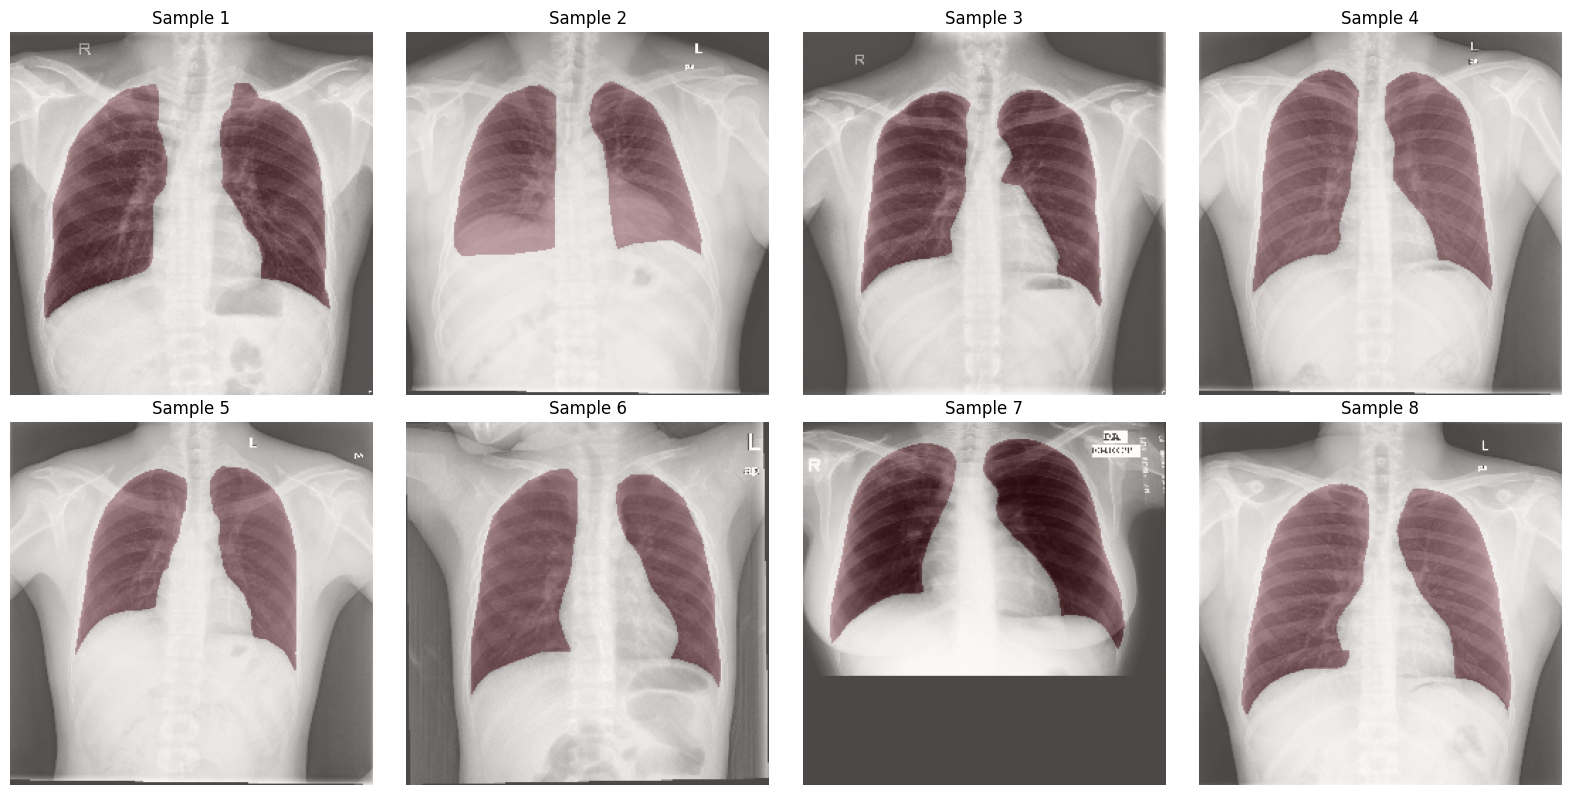

In [26]:
def visualize_samples(samples):
    num_samples = len(samples)
    cols = 4
    rows = num_samples // cols
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(16, 8))

    for i, sample in enumerate(samples):
        image = sample['image'].squeeze().numpy()
        mask = sample['mask'].squeeze().numpy()

        r = i // cols
        c = i % cols

        ax = axes[r, c]
        ax.imshow(image, cmap='gray')
        ax.imshow(mask, cmap='Reds', alpha=0.3)
        ax.axis('off')
        ax.set_title(f'Sample {i+1}')

    plt.tight_layout()
    plt.show()

random_indices = np.random.choice(len(test_dataset), 8, replace=False)
random_samples = [test_dataset[i] for i in random_indices]
visualize_samples(random_samples)

<h4> <strong>  6) DataLoader Initialization: </strong> </h4>
 
- initializes PyTorch DataLoader objects for the training, validation, and test datasets using a batch size of 16. 

In [27]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"train batches: {len(train_loader)} ---> {len(train_loader)*BATCH_SIZE} samples")
print(f"validation batches: {len(validation_loader)} ---> {len(validation_loader)*BATCH_SIZE} samples")
print(f"test batches: {len(test_loader)} ---> {len(test_loader)*BATCH_SIZE} samples")

train batches: 29 ---> 464 samples
validation batches: 7 ---> 112 samples
test batches: 9 ---> 144 samples


<h4> <strong>  7)  Dice Loss: </strong> </h4>

- defines DiceLoss() class, used in segmentation tasks to measure overlap between predicted and ground truth masks. 

In [28]:
class DiceLoss(nn.Module):
    def __init__(self, s=1e-6):
        super(DiceLoss, self).__init__()
        self.s = s

    def forward(self, p, t):
        p = p.contiguous().view(-1)
        t = t.contiguous().view(-1)
        dice_score = 1 - (((2. * ((p * t).sum())) + self.s) / ((p.pow(2).sum()) + (t.pow(2).sum()) + self.s))
        return dice_score

<h4> <strong>  8)  Model Initialization and Training Setup: </strong> </h4>

- initializes the UNet++ model using a ResNet-101 encoder pre-trained on ImageNet, customized for grayscale input and binary segmentation 
- sets up the loss function, optimizer, and model hyperparameters

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = smp.Unet(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=1,
    classes=1,
    activation=None,
    decoder_dropout=0.3
)
model = model.to(device)

criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 20

<h4> <strong>  9)  Model Training and Validation: </strong> </h4>

- trains the UNet++ model  
- every 2 epochs, visualizes a few validation samples showing the input image, ground truth mask, and model predictions

Epoch 1/20 - Train Loss: 0.2077 - Val Loss: 0.1495 - Time: 14.08s
Epoch 2/20 - Train Loss: 0.0672 - Val Loss: 0.0667 - Time: 13.98s


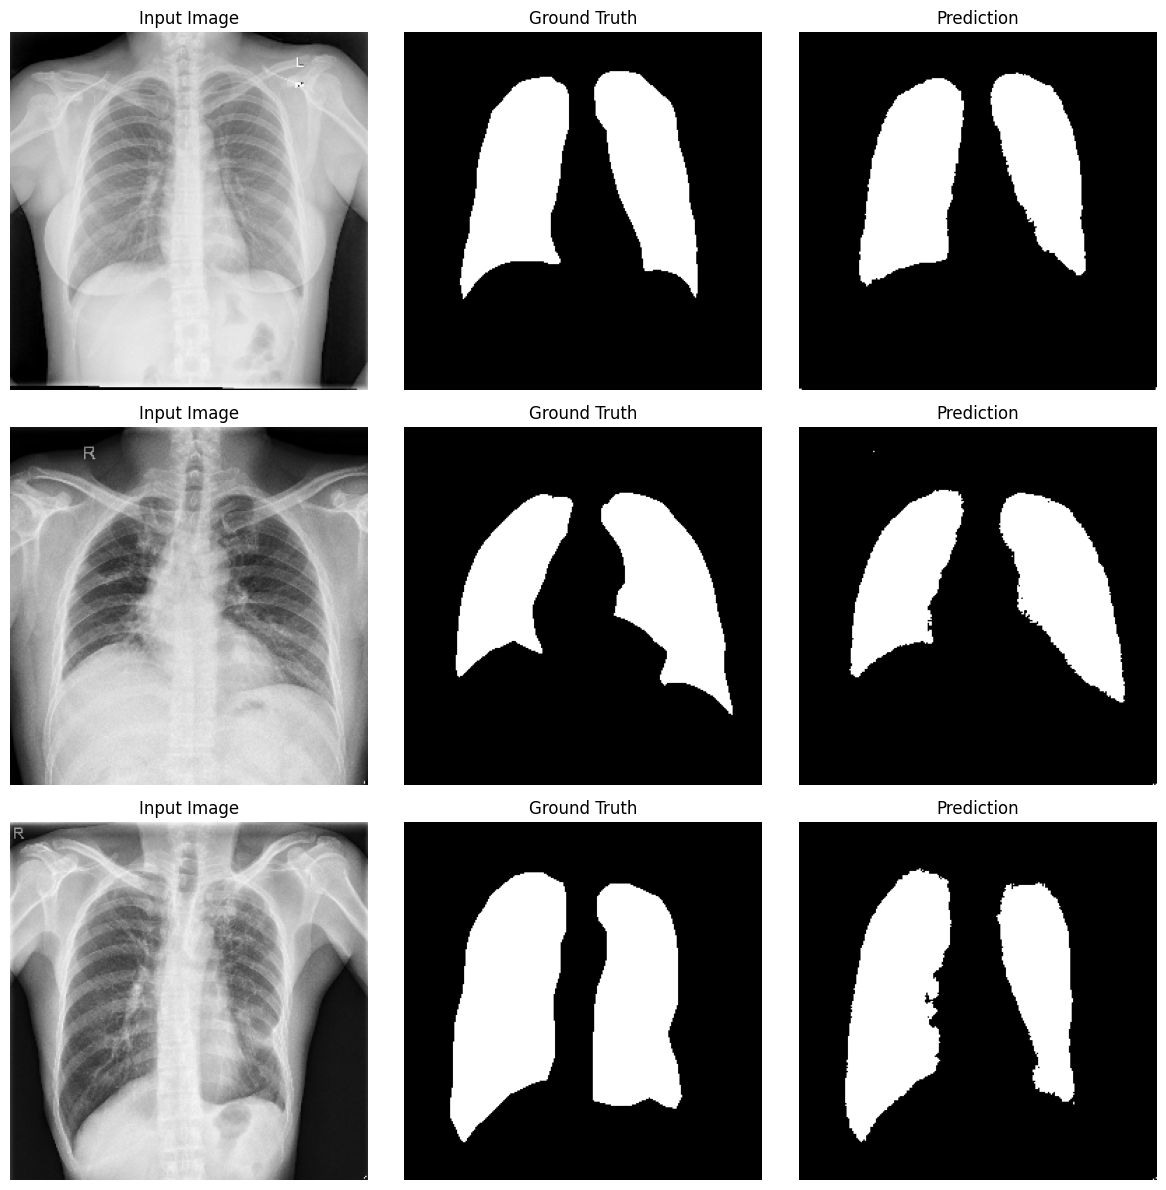

Epoch 3/20 - Train Loss: 0.0457 - Val Loss: 0.0468 - Time: 13.49s
Epoch 4/20 - Train Loss: 0.0369 - Val Loss: 0.0399 - Time: 13.34s


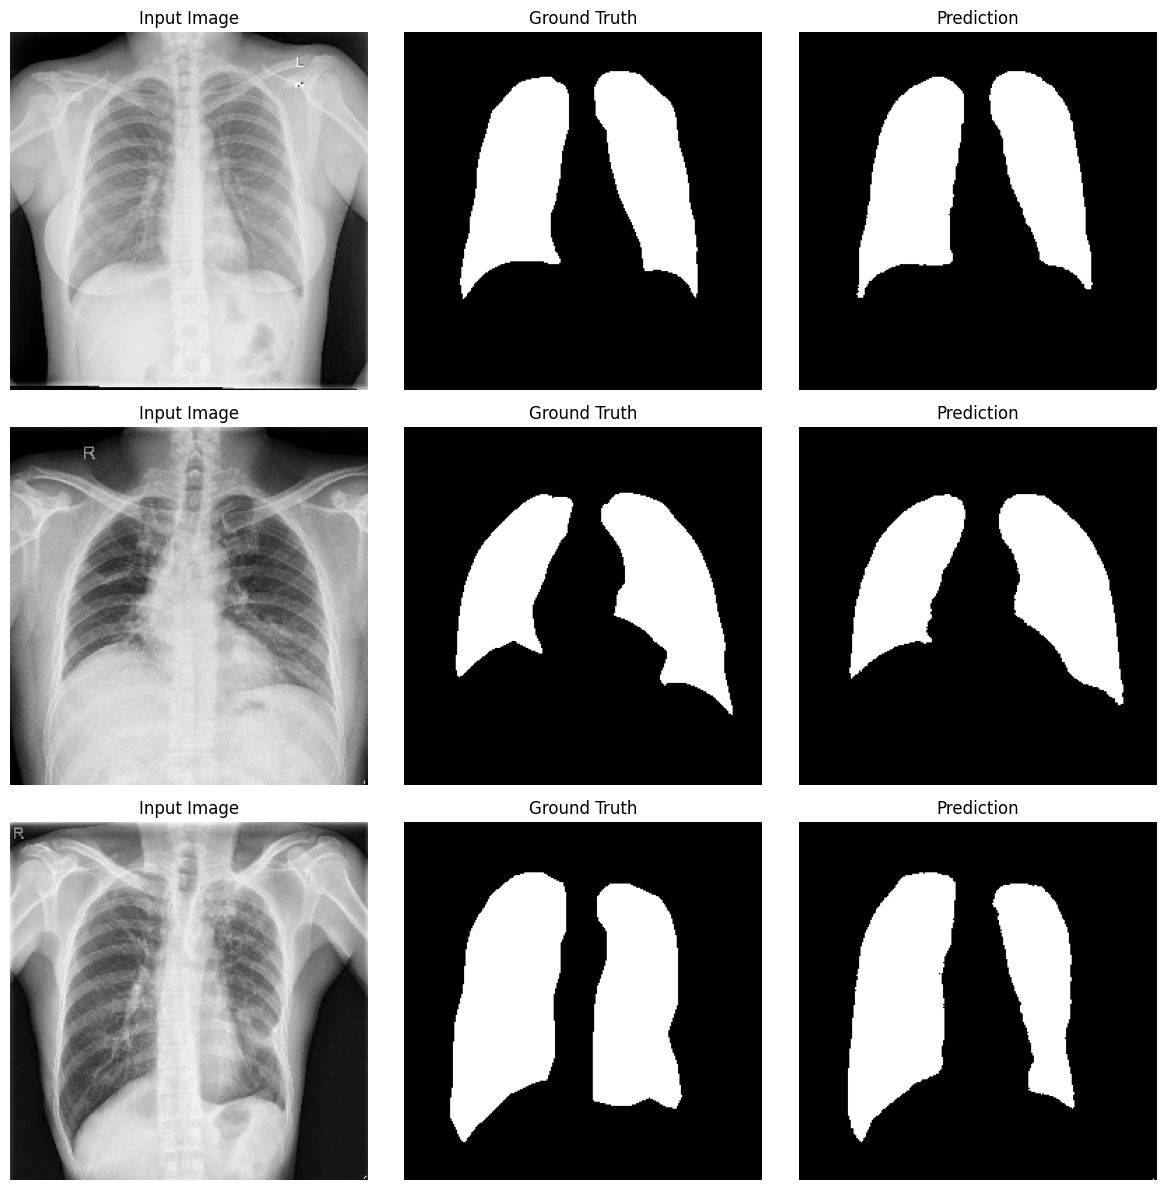

Epoch 5/20 - Train Loss: 0.0321 - Val Loss: 0.0385 - Time: 13.28s
Epoch 6/20 - Train Loss: 0.0279 - Val Loss: 0.0357 - Time: 13.35s


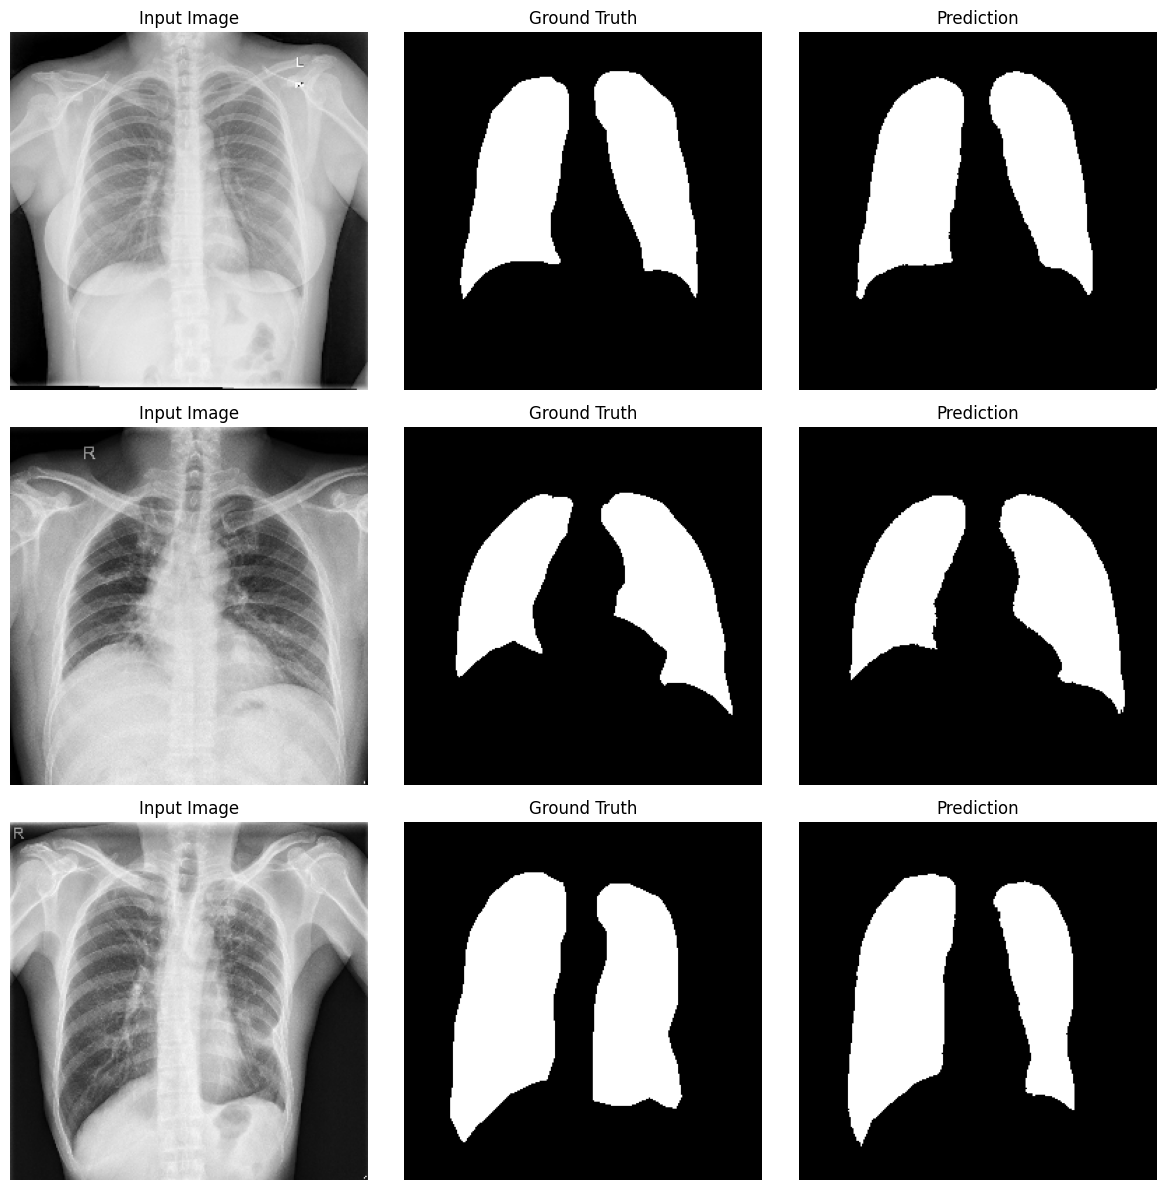

Epoch 7/20 - Train Loss: 0.0245 - Val Loss: 0.0348 - Time: 13.50s
Epoch 8/20 - Train Loss: 0.0227 - Val Loss: 0.0342 - Time: 13.56s


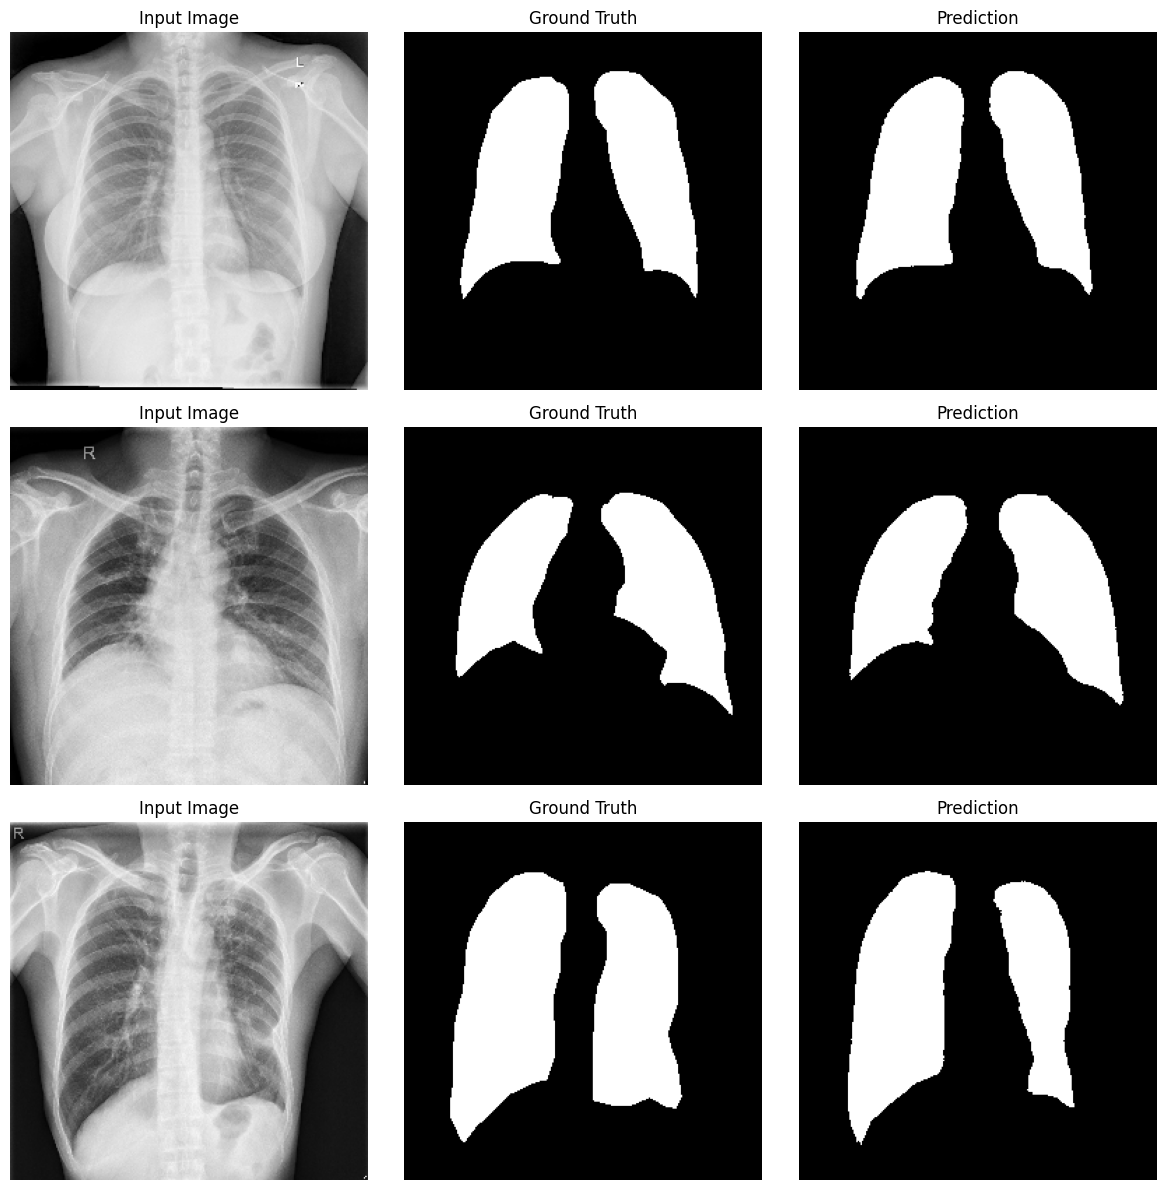

Epoch 9/20 - Train Loss: 0.0220 - Val Loss: 0.0341 - Time: 13.50s
Epoch 10/20 - Train Loss: 0.0203 - Val Loss: 0.0329 - Time: 13.46s


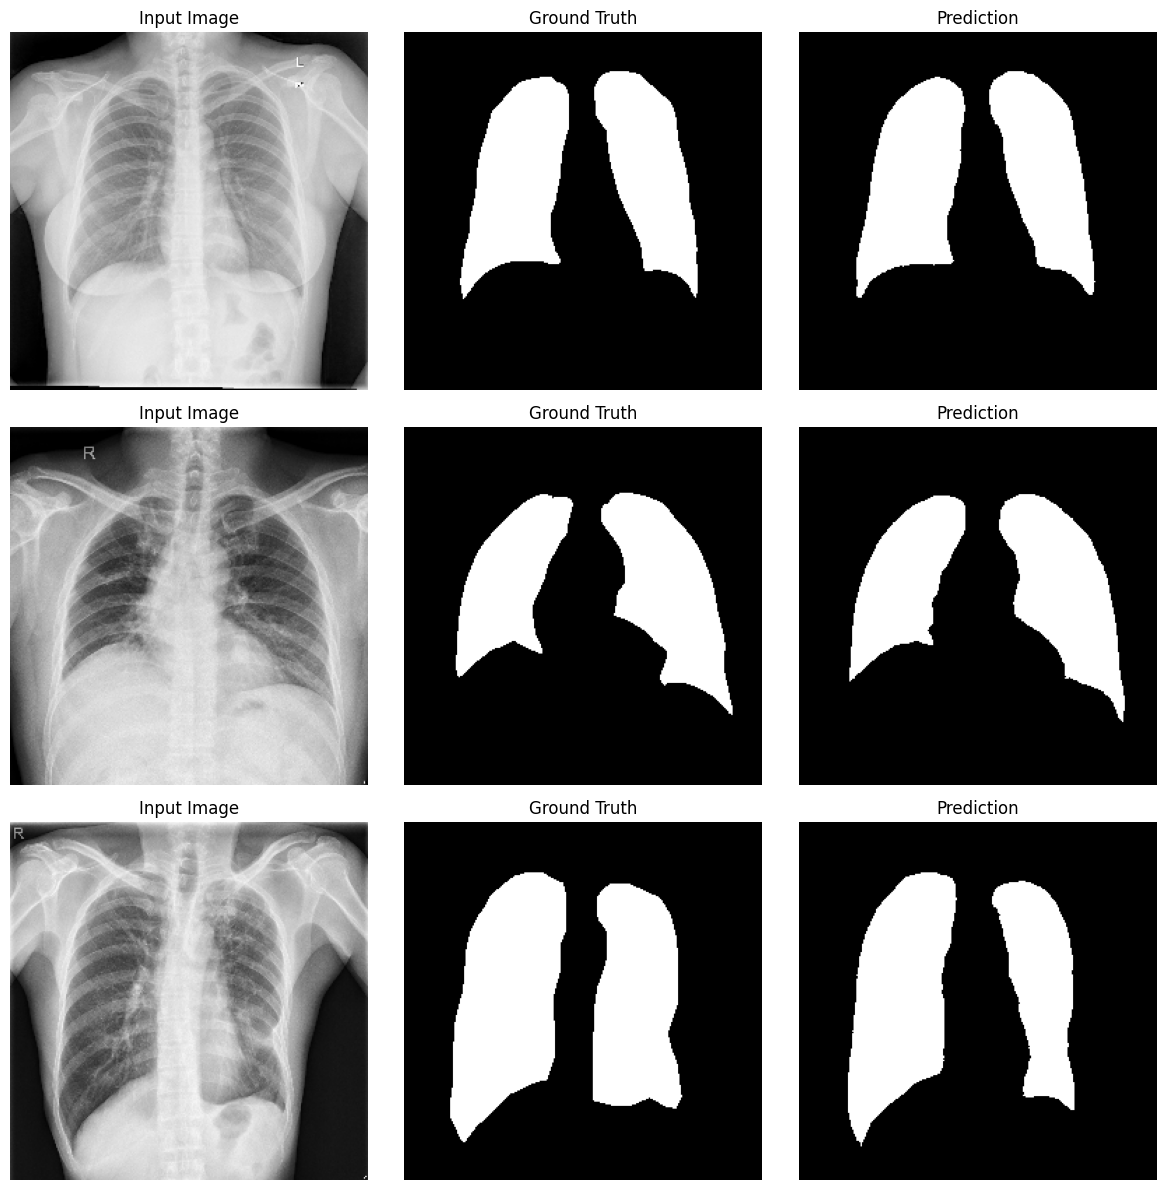

Epoch 11/20 - Train Loss: 0.0194 - Val Loss: 0.0330 - Time: 13.41s
Epoch 12/20 - Train Loss: 0.0182 - Val Loss: 0.0328 - Time: 13.42s


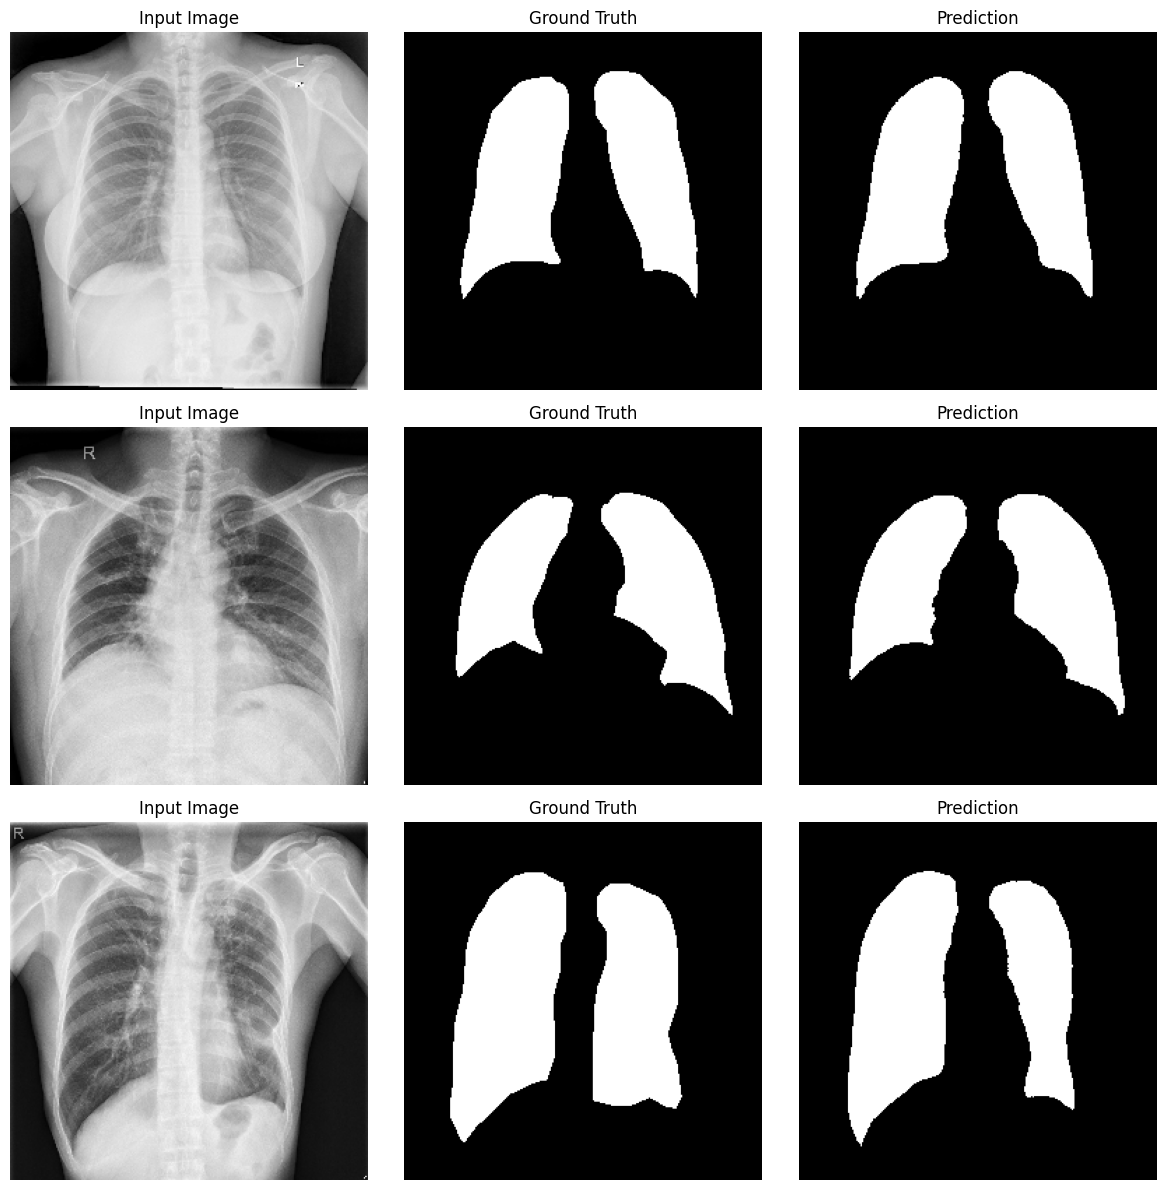

Epoch 13/20 - Train Loss: 0.0173 - Val Loss: 0.0317 - Time: 13.42s
Epoch 14/20 - Train Loss: 0.0157 - Val Loss: 0.0321 - Time: 13.47s


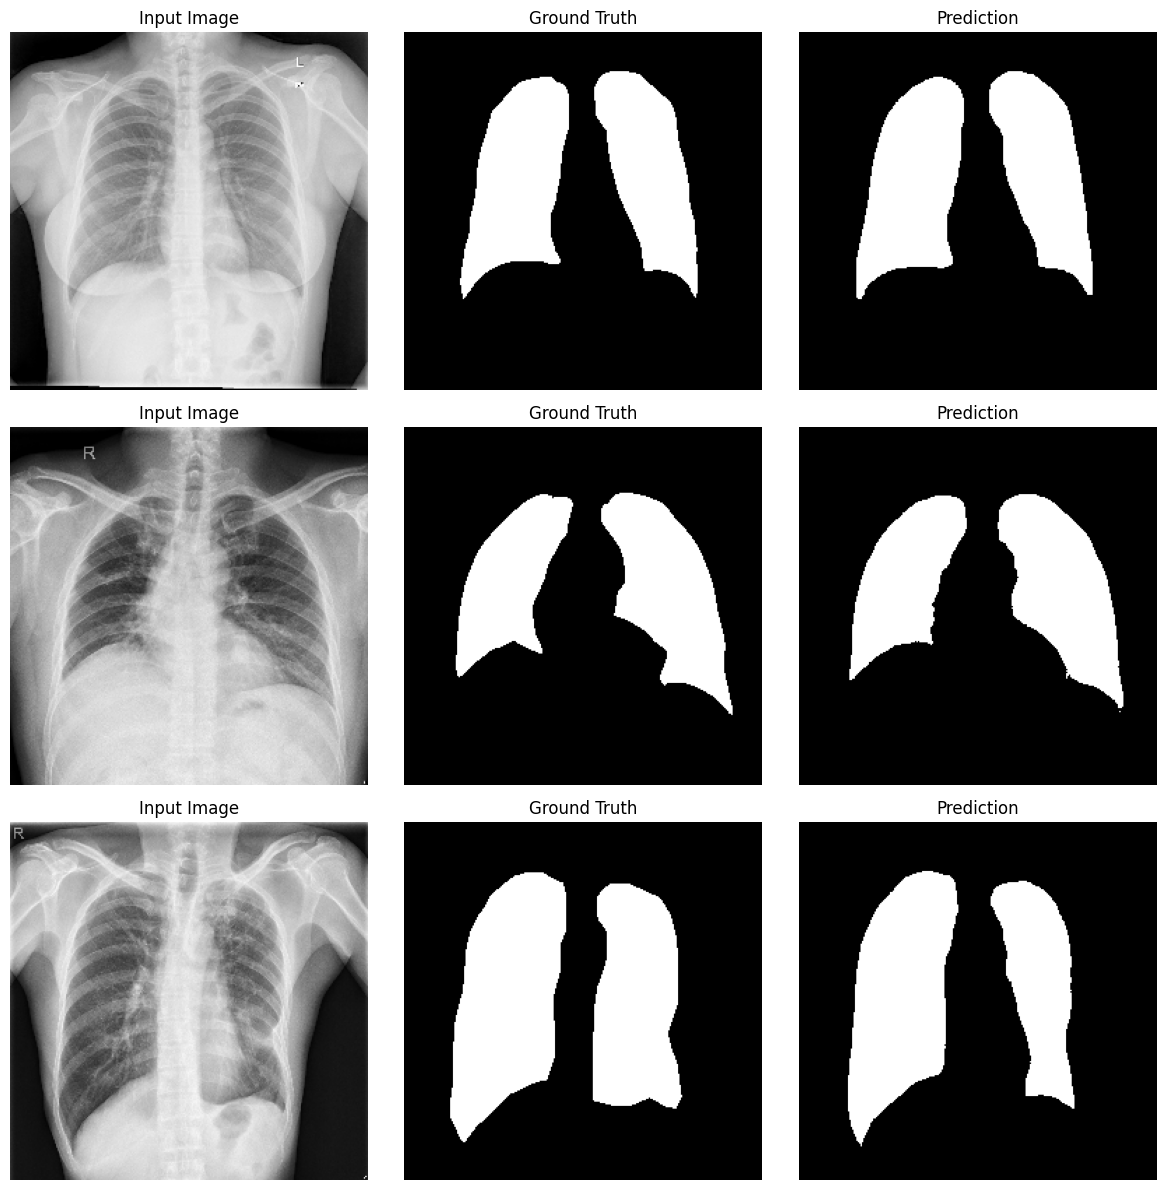

Epoch 15/20 - Train Loss: 0.0150 - Val Loss: 0.0322 - Time: 13.46s
Epoch 16/20 - Train Loss: 0.0149 - Val Loss: 0.0322 - Time: 13.48s


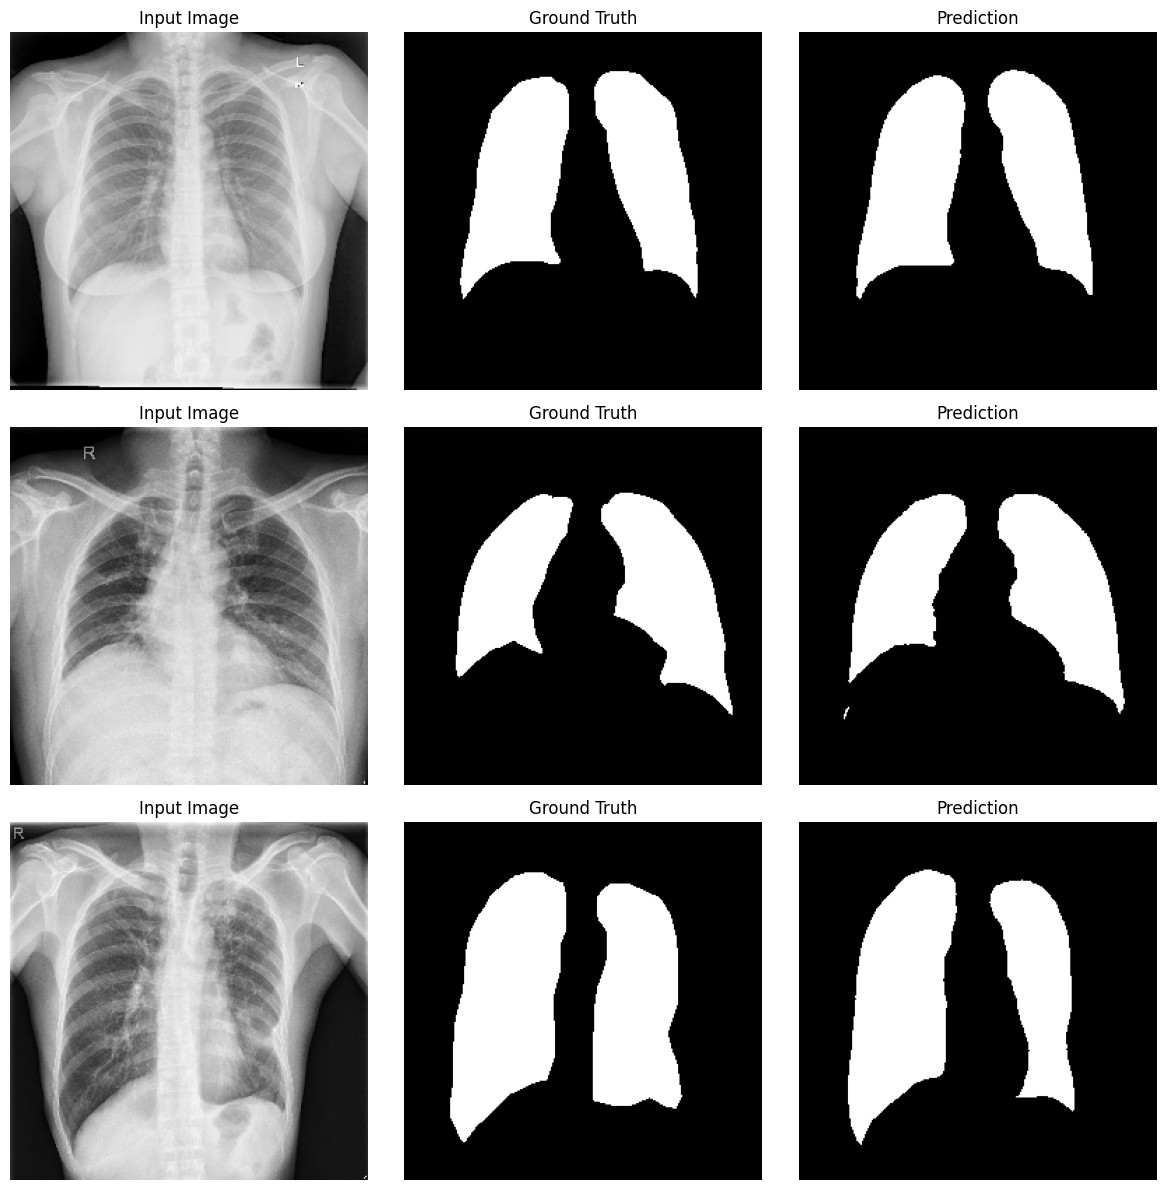

Epoch 17/20 - Train Loss: 0.0144 - Val Loss: 0.0316 - Time: 13.45s
Epoch 18/20 - Train Loss: 0.0143 - Val Loss: 0.0318 - Time: 13.45s


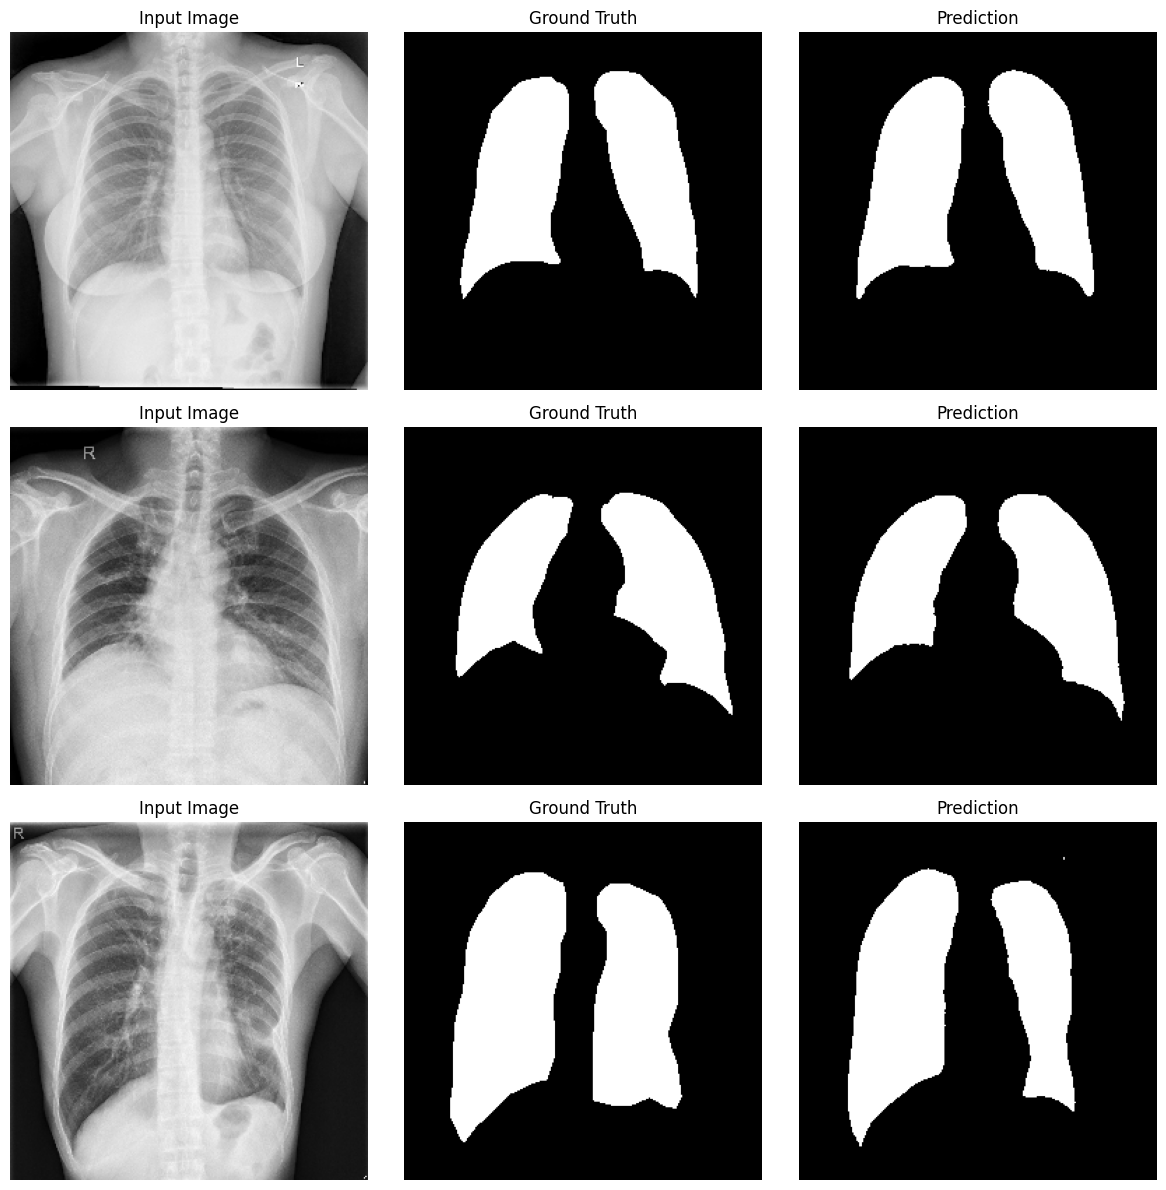

Epoch 19/20 - Train Loss: 0.0141 - Val Loss: 0.0314 - Time: 13.44s
Epoch 20/20 - Train Loss: 0.0138 - Val Loss: 0.0322 - Time: 13.44s


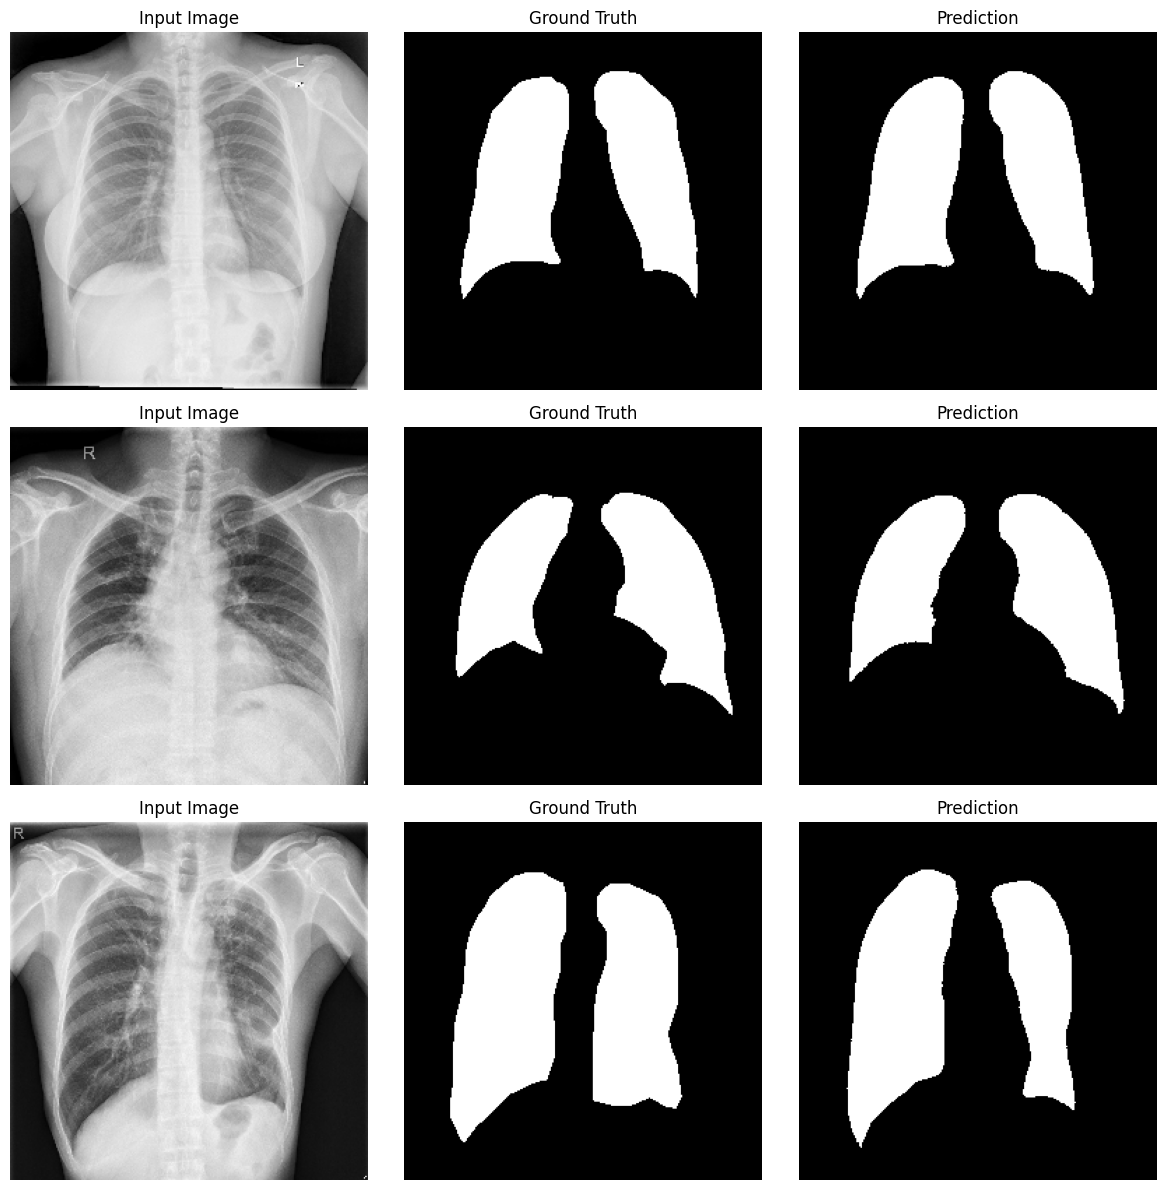

In [31]:
train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    model.train()
    train_loss = 0.0

    for batch in train_loader:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        outputs = torch.sigmoid(outputs)

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in validation_loader:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            outputs = model(images)
            outputs = torch.sigmoid(outputs)

            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    val_loss = val_loss / len(validation_loader.dataset)
    val_losses.append(val_loss)

    elapsed = time.time() - start_time
    print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Time: {elapsed:.2f}s")

    if epoch % 2 == 0:
        model.eval()
        sample_batch = next(iter(validation_loader))
        sample_images = sample_batch['image'].to(device)
        sample_masks = sample_batch['mask'].to(device)

        with torch.no_grad():
            preds = model(sample_images)
            preds = torch.sigmoid(preds)
            preds = (preds > 0.5).float()

        sample_images = sample_images.cpu().numpy()
        sample_masks = sample_masks.cpu().numpy()
        preds = preds.cpu().numpy()

        num_show = min(3, sample_images.shape[0])
        fig, axes = plt.subplots(num_show, 3, figsize=(12, num_show * 4))
        for i in range(num_show):
            axes[i, 0].imshow(sample_images[i, 0], cmap='gray')
            axes[i, 0].set_title("Input Image")
            axes[i, 0].axis("off")

            axes[i, 1].imshow(sample_masks[i, 0], cmap='gray')
            axes[i, 1].set_title("Ground Truth")
            axes[i, 1].axis("off")

            axes[i, 2].imshow(preds[i, 0], cmap='gray')
            axes[i, 2].set_title("Prediction")
            axes[i, 2].axis("off")
        plt.tight_layout()
        plt.show()

<h4> <strong>  10)  Model Evaluation: </strong> </h4>

- evaluates the trained model on the test dataset  
- plots the training and validation loss curves over all epochs, helping visualize model performance

Test Loss: 0.0366


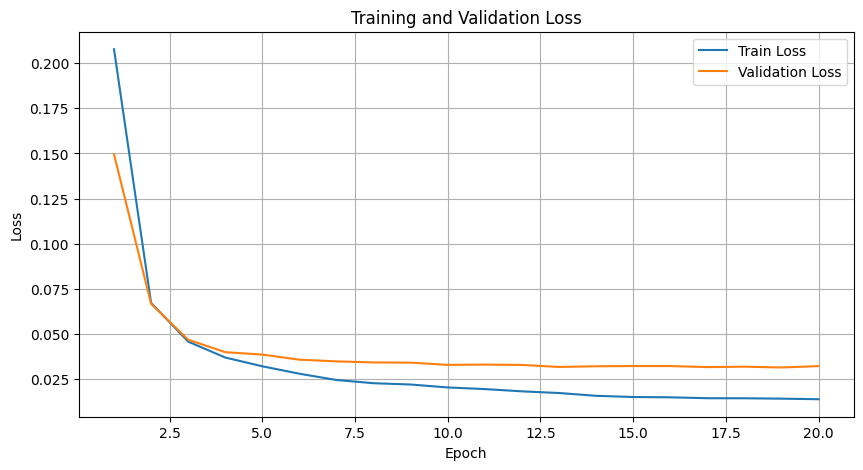

In [32]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        outputs = model(images)
        outputs = torch.sigmoid(outputs)

        loss = criterion(outputs, masks)
        test_loss += loss.item() * images.size(0)

test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

<h4> <strong>  11) Evaluation Metrics </strong> </h4>

- defines functions to compute Dice Coefficient and Intersection-over-Union (IoU), which are standard metrics for evaluating segmentation performance

In [33]:
# --- Evaluation (Dice and IoU) ---
def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask * groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = (2 * intersect) / total_sum if total_sum > 0 else 1.0
    return dice

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask * groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou_value = intersect / union if union > 0 else 1.0
    return iou_value

all_dice = []
all_iou = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        outputs_bin = (outputs >= 0.5).float()

        for i in range(outputs_bin.size(0)):
            pred_np = outputs_bin[i].cpu().numpy().squeeze()
            mask_np = masks[i].cpu().numpy().squeeze()
            dice_score = dice_coef(mask_np, pred_np)
            iou_score = iou(mask_np, pred_np)
            all_dice.append(dice_score)
            all_iou.append(iou_score)

mean_dice = np.mean(all_dice)
mean_iou = np.mean(all_iou)

print("Dice Coefficient on Test Set: {:.4f}".format(mean_dice))
print("IoU on Test Set: {:.4f}".format(mean_iou))

Dice Coefficient on Test Set: 0.9561
IoU on Test Set: 0.9173


<h4> <strong>  12) Saving the Trained Model: </strong> </h4>

- saves the trained UNet++ model’s weights 
- allows for reloading the model later without retraining

In [34]:
torch.save(model.state_dict(), 'UNet.pth')
print("Model saved")

Model saved
